<a href="https://colab.research.google.com/github/Rahulx911/grid-6.0/blob/main/Freshness_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

# Set the seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# List of produce types (fruits and vegetables)
produce_types = [
    'Apple', 'Banana', 'Mango', 'Strawberry',  # Fruits
    'Bellpepper', 'Carrot', 'Cucumber', 'Potato', 'Tomato'  # Vegetables
]
num_classes = len(produce_types)  # We have 9 produce types in total

# Paths to the dataset
dataset_dir = '/content/drive/MyDrive/Fruits_Vegetables_Dataset(12000)'

# ImageDataGenerator without augmentations
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    validation_split=0.2  # Split dataset into training and validation
)

# Function to create ResNet-50 model for multi-output (produce type + freshness)
def create_model(input_shape=(160, 160, 3), num_classes=9):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)  # Dropout for regularization

    # Output 1: Produce Type Classification (9 classes: Apple, Banana, etc.)
    produce_type_output = Dense(num_classes, activation='softmax', name='produce_type_output',
                                kernel_regularizer=l2(0.001))(x)

    # Output 2: Freshness Classification (binary: fresh or rotten)
    freshness_output = Dense(1, activation='sigmoid', name='freshness_output',
                             kernel_regularizer=l2(0.001))(x)

    # Create the model with two outputs
    model = Model(inputs=base_model.input, outputs=[produce_type_output, freshness_output])

    # Compile the model with two losses (one for each output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss={
            'produce_type_output': 'categorical_crossentropy',  # Multi-class classification for produce type
            'freshness_output': 'binary_crossentropy'  # Binary classification for freshness
        },
        metrics={
            'produce_type_output': 'accuracy',
            'freshness_output': 'accuracy'
        }
    )

    return model

# Training for all produce types (fruits and vegetables)
def train_model():
    # Load data
    train_generator = datagen.flow_from_directory(
        dataset_dir,
        target_size=(160, 160),
        batch_size=128,
        class_mode=None,  # Custom class mode for multi-output
        subset='training',
        shuffle=True
    )

    validation_generator = datagen.flow_from_directory(
        dataset_dir,
        target_size=(160, 160),
        batch_size=128,
        class_mode=None,
        subset='validation',
        shuffle=True
    )

    # Create the multi-output model
    model = create_model()

    # Callbacks for learning rate reduction and model checkpointing
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
    model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', verbose=1)

    # Train the model
    history = model.fit(
        multi_output_data_generator(train_generator),
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=multi_output_data_generator(validation_generator),
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        epochs=100,
        callbacks=[reduce_lr, model_checkpoint]
    )


    model.save('final_unified_model.keras')

    print("Training completed!")

# Custom data generator to yield both produce type and freshness labels
def multi_output_data_generator(generator):
    while True:
        images = next(generator)
        batch_size = images.shape[0]
        produce_labels = np.zeros((batch_size, num_classes))  # One-hot encoding for produce types
        freshness_labels = np.zeros((batch_size, 1))  # Binary encoding for freshness (fresh=1, rotten=0)

        for i, filename in enumerate(generator.filenames[generator.batch_index - batch_size:generator.batch_index]):
            # Get the directory name (FreshApple, RottenApple, etc.)
            dir_name = os.path.split(os.path.dirname(filename))[-1]

            # Determine the freshness (fresh or rotten)
            freshness = 1 if 'Fresh' in dir_name else 0

            # Determine the produce type based on directory name
            produce_type = [p for p in produce_types if p.lower() in dir_name.lower()]
            if produce_type:
                produce_type_index = produce_types.index(produce_type[0])
                produce_labels[i, produce_type_index] = 1  # One-hot encoding for produce type
                freshness_labels[i] = freshness

        yield images, {'produce_type_output': produce_labels, 'freshness_output': freshness_labels}


train_model()



Found 9590 images belonging to 2 classes.
Found 2396 images belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/100
 6/74 ━━━━━━━━━━━━━━━━━━━━ 58:44 52s/step - freshness_output_accuracy: 0.5480 - loss: 1.0799 - produce_type_output_accuracy: 0.0944

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 63s/step - freshness_output_accuracy: 0.5182 - loss: 1.0374 - produce_type_output_accuracy: 0.0965  
Epoch 1: val_loss improved from inf to 0.75135, saving model to best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 5884s 79s/step - freshness_output_accuracy: 0.5181 - loss: 1.0371 - produce_type_output_accuracy: 0.0964 - val_freshness_output_accuracy: 0.2201 - val_loss: 0.7513 - val_produce_type_output_accuracy: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - freshness_output_accuracy: 0.5210 - loss: 0.9339 - produce_type_output_accuracy: 0.0948
Epoch 2: val_loss improved from 0.75135 to 0.46045, saving model to best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 122s 906ms/step - freshness_output_accuracy: 0.5210 - loss: 0.9339 - produce_type_output_accuracy: 0.0948 - val_freshness_output_accuracy: 0.9228 - val_loss: 0.4605 - val_produce_type_output_accuracy: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 3/100
74/74 ━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Category: Fruit
Predicted Produce Type: Apple
Freshness Index: 0.16
The produce is: Not Fresh
Estimated shelf life: Less than 1 day


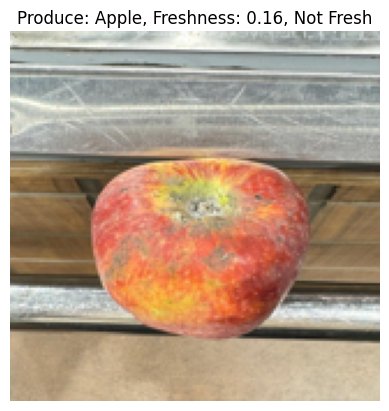

In [5]:
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

# List of fruits and vegetables for classification
fruits = ['Apple', 'Banana', 'Mango', 'Strawberry']
vegetables = ['Bellpepper', 'Carrot', 'Cucumber', 'Potato', 'Tomato']

produce_types = fruits + vegetables  # Combine fruits and vegetables

model = tf.keras.models.load_model('final_unified_model.keras')  # Corrected file path without the space



# Function to preprocess the user-provided image for the model
def preprocess_image(image_path):
    image = Image.open(image_path)
    if image.mode == 'RGBA':
        image = image.convert('RGB')
    image = image.resize((160, 160))  # Resize to match model input
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Function to make predictions and classify produce type and freshness
def predict_produce_type_and_freshness(image_path):
    image = preprocess_image(image_path)

    # Make predictions using the model
    produce_pred, freshness_pred = model.predict(image)

    # Get the predicted produce type (argmax to get the class index)
    produce_type_index = np.argmax(produce_pred[0])
    produce_type = produce_types[produce_type_index]

    # Determine if it's a fruit or vegetable
    category = "Fruit" if produce_type in fruits else "Vegetable"

    # Get the predicted freshness index (0 to 1, sigmoid output)
    freshness_index = freshness_pred[0][0]  # [0][0] to get the first prediction value

    # Determine freshness classification
    is_fresh = "Fresh" if freshness_index > 0.5 else "Not Fresh"

    return category, produce_type, freshness_index, is_fresh

# Function to estimate shelf life based on freshness index
def predict_shelf_life(freshness_index):
    if freshness_index > 0.8:
        return "Estimated shelf life: 7+ days"
    elif 0.5 < freshness_index <= 0.8:
        return "Estimated shelf life: 3-7 days"
    elif 0.3 < freshness_index <= 0.5:
        return "Estimated shelf life: 1-3 days"
    else:
        return "Estimated shelf life: Less than 1 day"

# Main function to check the user-provided image
def check_image(image_path):
    # Predict the produce type and freshness
    category, produce_type, freshness_index, is_fresh = predict_produce_type_and_freshness(image_path)

    # Estimate shelf life
    shelf_life = predict_shelf_life(freshness_index)

    # Display the results
    print(f"Category: {category}")
    print(f"Predicted Produce Type: {produce_type}")
    print(f"Freshness Index: {freshness_index:.2f}")
    print(f"The produce is: {is_fresh}")
    print(shelf_life)

    # Optionally, display the image with the predicted result
    image = preprocess_image(image_path)[0]  # Remove batch dimension for visualization
    plt.imshow(image)
    plt.title(f"Produce: {produce_type}, Freshness: {freshness_index:.2f}, {is_fresh}")
    plt.axis('off')
    plt.show()

# Test with a user-provided image (provide the actual image path)
image_path = '/content/apple_rotten_image.jpeg'  # Update this with your actual image path
check_image(image_path)

